In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Loading the data

Use only the following columns:

    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'

* Fill NAs with 0.
* Apply the log tranform to median_house_value.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.
* Use DictVectorizer to turn the dataframe into matrices.


In [2]:
df = pd.read_csv("housing.csv")
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [3]:
check_nan = df.isnull().values.any()
check_nan

True

In [4]:
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [5]:
mhv_logs = np.log1p(df.median_house_value)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df, test_size=0.25, random_state=1)

In [8]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train["median_house_value"]
del df_test["median_house_value"]
del df_val["median_house_value"]

In [9]:
from sklearn.feature_extraction import DictVectorizer

In [10]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")
test_dicts = df_test.to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

Answer Q1

* `ocean_proximity=INLAND`


In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

[Text(0.5, 0.75, 'X[6] <= 0.5\nsquared_error = 0.323\nsamples = 15480\nvalue = 12.09'),
 Text(0.25, 0.25, 'squared_error = 0.213\nsamples = 10591\nvalue = 12.309'),
 Text(0.75, 0.25, 'squared_error = 0.23\nsamples = 4889\nvalue = 11.614')]

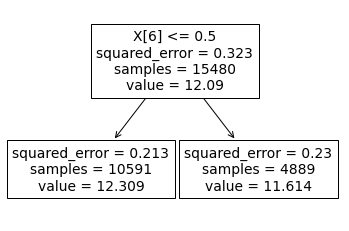

In [13]:
from sklearn import tree

tree.plot_tree(dt)

In [15]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

Answer Q2

* 0.25

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [17]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
y_pred = rfr.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

0.24

Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

Answer Q3

* 150

In [19]:
from tqdm.auto import tqdm

In [20]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

  0%|          | 0/20 [00:00<?, ?it/s]

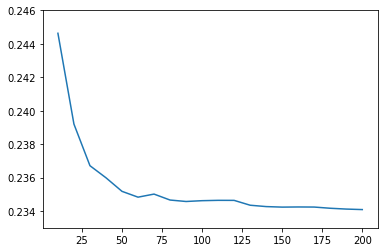

In [21]:
columns = ["n_est", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.n_est, df_scores.rmse)
plt.ylim(0.233, 0.246)
plt.show()

Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`?

Answer Q4

* 25

In [22]:
scores = []

for d in tqdm([10, 15, 20, 25]):

    for n in tqdm(range(10, 201, 10)):

        rfr = RandomForestRegressor(
            n_estimators=n, max_depth=d, random_state=1, n_jobs=-1
        )
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n, d, score))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
columns = ["n_est", "max_depth", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_est,max_depth,rmse
0,10,10,0.257959
1,20,10,0.256428
2,30,10,0.255508
3,40,10,0.255020
4,50,10,0.254834
...,...,...,...
75,160,25,0.234515
76,170,25,0.234563
77,180,25,0.234524
78,190,25,0.234437


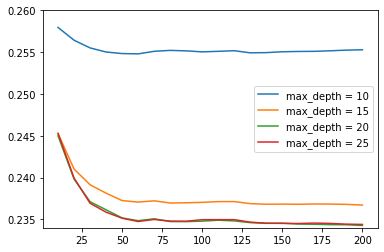

In [24]:
for d in [10, 15, 20, 25]:
    depth_df = df_scores[df_scores.max_depth == d]
    plt.plot(depth_df.n_est, depth_df.rmse, label=f"max_depth = {d}")

plt.legend()
plt.ylim(0.234, 0.26)
plt.show()

Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

Answer Q6
* `median_income`	


In [25]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
rfr.feature_importances_

array([1.74994885e-02, 3.20541395e-02, 1.03855301e-01, 9.57711912e-02,
       3.47413983e-01, 2.47211049e-03, 3.25677204e-01, 9.71163374e-05,
       2.43749568e-04, 3.75232960e-03, 3.04049105e-02, 1.83320737e-02,
       2.24264023e-02])

In [27]:
importances = rfr.feature_importances_
features = dv.get_feature_names_out()
feature_importance = pd.DataFrame(importances, index=features)
feature_importance

,0
households,0.017499
housing_median_age,0.032054
latitude,0.103855
longitude,0.095771
median_income,0.347414
ocean_proximity=<1H OCEAN,0.002472
ocean_proximity=INLAND,0.325677
ocean_proximity=ISLAND,0.000097
ocean_proximity=NEAR BAY,0.000244
ocean_proximity=NEAR OCEAN,0.003752


<AxesSubplot: >

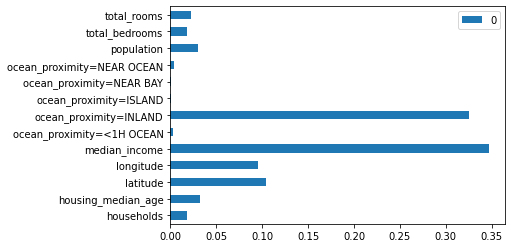

In [28]:
feature_importance.plot.barh()

Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

Answer Q6. 
* 0.1


In [29]:
import xgboost as xgb
import re

In [30]:
features = dv.get_feature_names_out()

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
features = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in features
]

d_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_rmse", "val_rsme"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [32]:
watchlist = [(d_train, "train"), (d_val, "val")]

In [33]:
scores_eta = {}

In [36]:
%%capture output
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, d_train, evals=watchlist, num_boost_round=100)

In [37]:
key_text_eta = f"eta = {xgb_params['eta']}"
scores_eta[key_text_eta] = parse_xgb_output(output)
key_text_eta

'eta = 0.1'

In [38]:
scores_eta.keys()

dict_keys(['eta = 0.3', 'eta = 0.1'])

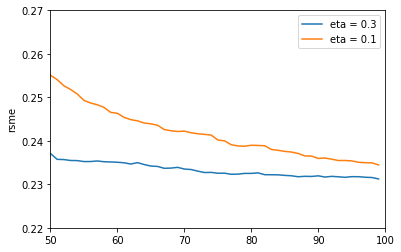

In [41]:
for key_eta, df_score in scores_eta.items():
    plt.plot(df_score.num_iter, df_score.val_rsme, label=key_eta)

plt.ylabel("rsme")

plt.xlim((50, 100))
plt.ylim((0.22, 0.27))
plt.legend()
plt.show()